# VPTQ - Vector Post-Training Quantization

In the following notebook, we'll explore the [VPTQ: Extreme Low-bit Vector Post-Training Quantization for Large Language Models](https://github.com/microsoft/VPTQ/blob/main/VPTQ_tech_report.pdf) method of quantization!

This will be the third in our series on quantization methods, following the [AWQ Event](https://www.youtube.com/watch?v=BEDHx_drhHQ), and [GPTQ Event](https://www.youtube.com/watch?v=xmaG4al2A6E)!

We will compare and contrast VPTQ against the other methods on a few important metrics:

1. **Time to First Token** (*TTFT*): How long does it take before our endpoint starts returning tokens, TTFT is key in creating applications that *feel* responsive due to responses from LLMs typically being streamed to users as tokens are generated.
2. **Inter-Token Latency** (*ITL*): Inter-Token Latency talks about the amount of time between tokens being generated. Lower ITL helps the response come through fast enough to keep up with typical reading speeds.
3. **Tokens Per Second** (*TPS*): A classic metric that simply indicates how many Tokens are produced per second.

Before we get into VPTQ, we'll need to create a method to capture these metrics for us - let's do that by extending the `transformers` `TextStreamer` class!

In [ ]:
%%capture
!pip install vptq
!pip install -U transformers==4.46.0 accelerate

In [ ]:
!pip install -qU autoawq accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -qU --no-build-isolation auto-gptq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 81.6 MB/s eta 0:00:00


In [ ]:
!pip3 install -qU torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

> NOTE: You may need to restart your Colab environment after running the above `pip install` code cells and continue running the notebook from this cell.

## Extending `TextStreamer`

All we really need to do is capture timings of when tokens are generated - we can do this straightforwardly as we see below - this will allow us to capture the relevant information we need to calculate our desired metrics.

In [ ]:
import time
from typing import Dict, Any, List
from transformers import TextStreamer
import torch
import numpy as np
from tqdm import tqdm
from statistics import mean, median, stdev
from dataclasses import dataclass
from typing import Optional

@dataclass
class AggregateMetrics:
    mean_total_time: float
    std_total_time: float
    mean_first_token: float
    std_first_token: float
    mean_tokens_per_second: float
    std_tokens_per_second: float
    mean_inter_token_latency: float
    std_inter_token_latency: float
    median_inter_token_latency: float
    p90_inter_token_latency: float
    total_tokens: int
    num_samples: int
    failed_runs: int

    def __str__(self) -> str:
        return f"""Aggregate Metrics (across {self.num_samples} successful runs):
Total time: {self.mean_total_time:.3f}s ± {self.std_total_time:.3f}s
Time to first token: {self.mean_first_token:.3f}s ± {self.std_first_token:.3f}s
Tokens per second: {self.mean_tokens_per_second:.1f} ± {self.std_tokens_per_second:.1f}
Mean inter-token latency: {self.mean_inter_token_latency*1000:.2f}ms ± {self.std_inter_token_latency*1000:.2f}ms
Median inter-token latency: {self.median_inter_token_latency*1000:.2f}ms
P90 inter-token latency: {self.p90_inter_token_latency*1000:.2f}ms
Total tokens generated: {self.total_tokens}
Failed runs: {self.failed_runs}"""

class TimingStreamer(TextStreamer):
    def __init__(self, tokenizer):
        super().__init__(tokenizer)
        self.generation_start_time = None
        self.first_token_time = None
        self.token_timestamps: List[float] = []
        self.num_tokens = 0

    def put(self, value):
        current_time = time.perf_counter()

        if self.first_token_time is None:
            self.first_token_time = current_time - self.generation_start_time

        self.token_timestamps.append(current_time - self.generation_start_time)
        self.num_tokens += 1
        super().put(value)

    def get_metrics(self) -> Dict[str, float]:
        if not self.token_timestamps:
            return {
                'total_time_s': 0,
                'time_to_first_token_s': 0,
                'tokens_per_second': 0,
                'mean_inter_token_latency_s': 0,
                'median_inter_token_latency_s': 0,
                'p90_inter_token_latency_s': 0,
                'num_tokens': 0
            }

        total_time = self.token_timestamps[-1]

        metrics = {
            'total_time_s': total_time,
            'time_to_first_token_s': self.first_token_time,
            'tokens_per_second': self.num_tokens / total_time if total_time > 0 else 0,
            'num_tokens': self.num_tokens
        }

        if self.num_tokens >= 2:
            inter_token_latencies = np.diff(self.token_timestamps)
            metrics.update({
                'mean_inter_token_latency_s': float(np.mean(inter_token_latencies)),
                'median_inter_token_latency_s': float(np.median(inter_token_latencies)),
                'p90_inter_token_latency_s': float(np.percentile(inter_token_latencies, 90))
            })
        else:
            metrics.update({
                'mean_inter_token_latency_s': 0,
                'median_inter_token_latency_s': 0,
                'p90_inter_token_latency_s': 0
            })

        return metrics

def time_generation(model, inputs: Dict[str, torch.Tensor], tokenizer, **gen_kwargs) -> Dict[str, float]:
    streamer = TimingStreamer(tokenizer)
    gen_kwargs['streamer'] = streamer

    streamer.generation_start_time = time.perf_counter()

    _ = model.generate(**inputs, **gen_kwargs)

    return streamer.get_metrics()

def run_benchmark(
    model,
    inputs: Dict[str, torch.Tensor],
    tokenizer,
    num_runs: int = 50,
    warmup_runs: int = 2,
    **gen_kwargs
) -> AggregateMetrics:
    """
    Run multiple generations and calculate aggregate statistics.

    Args:
        model: The model to benchmark
        inputs: Input tensors
        tokenizer: The tokenizer
        num_runs: Number of benchmark runs
        warmup_runs: Number of warmup runs to perform before benchmarking
        gen_kwargs: Additional generation kwargs

    Returns:
        AggregateMetrics containing aggregate statistics across all runs
    """
    # Perform warmup runs
    print(f"Performing {warmup_runs} warmup runs...")
    for _ in range(warmup_runs):
        _ = time_generation(model, inputs, tokenizer, **gen_kwargs)

    print(f"\nRunning {num_runs} benchmark iterations...")
    metrics_list = []
    failed_runs = 0

    # Run benchmarks
    for i in tqdm(range(num_runs)):
        try:
            metrics = time_generation(model, inputs, tokenizer, **gen_kwargs)
            metrics_list.append(metrics)
        except Exception as e:
            print(f"Run {i} failed with error: {str(e)}")
            failed_runs += 1

    if not metrics_list:
        raise RuntimeError("All benchmark runs failed!")

    # Calculate aggregate statistics
    successful_runs = len(metrics_list)

    def safe_std(values: List[float]) -> float:
        return stdev(values) if len(values) > 1 else 0

    total_times = [m['total_time_s'] for m in metrics_list]
    first_token_times = [m['time_to_first_token_s'] for m in metrics_list]
    tokens_per_second = [m['tokens_per_second'] for m in metrics_list]
    inter_token_latencies = [m['mean_inter_token_latency_s'] for m in metrics_list]
    median_latencies = [m['median_inter_token_latency_s'] for m in metrics_list]
    p90_latencies = [m['p90_inter_token_latency_s'] for m in metrics_list]
    total_tokens = sum(m['num_tokens'] for m in metrics_list)

    return AggregateMetrics(
        mean_total_time=mean(total_times),
        std_total_time=safe_std(total_times),
        mean_first_token=mean(first_token_times),
        std_first_token=safe_std(first_token_times),
        mean_tokens_per_second=mean(tokens_per_second),
        std_tokens_per_second=safe_std(tokens_per_second),
        mean_inter_token_latency=mean(inter_token_latencies),
        std_inter_token_latency=safe_std(inter_token_latencies),
        median_inter_token_latency=mean(median_latencies),
        p90_inter_token_latency=mean(p90_latencies),
        total_tokens=total_tokens,
        num_samples=successful_runs,
        failed_runs=failed_runs
    )

## Simple Benchmark

In the following cells, we'll load Meta's Llama 3.1 8B Instruct model using various quantization strategies - and then benchmark them on a simple generation.

We'll use this information to try and understand how each method compares to each other method!

Let's start with the newest method on the block: VPTQ!

### VPTQ

First, let's discuss a little bit about what is happening with VPTQ!

#### VPTQ Explained:

1. Instead of compressing weights one by one, group them into vectors to preserve their relationships and patterns
2. Channel-independent optimization means you can handle one vector at a time without errors cascading and accumulating throughout the matrix
3. Only about 1% of weights are "outliers" that need special high-precision handling - the rest can be heavily compressed
4. The lookup-table (codebook) approach means you can trade memory for speed - as long as your codebook fits in GPU cache, dequantization is fast
5. By aligning with hardware constraints (like 128-byte cache lines), you can achieve compression ratios and speeds that match or exceed full-precision operations
6. Codebooks are created using Hessian-weighted K-means clustering - meaning the most important weight patterns (according to the model's loss function) are preserved as centroids in the codebook

Let's expand a bit on the idea of a codebook:

#### VPTQ Codebook Explained:

1. **Basic Codebook**:
  - Instead of storing full weights, store an index (like a page number)
  - The index points to a representative vector in the codebook (like looking up a word's definition)
  - A typical setup might use vectors of length 6 with 4096 possible patterns (codebook entries)
2. **Memory vs Precision Trade-off:**
  - Smaller codebook = less memory but fewer possible patterns
  - Larger codebook = better precision but more memory usage
  - The sweet spot is when your codebook just fits in L1 cache (~128KB)
  - This is why vector length of 6-8 works well - longer vectors need exponentially larger codebooks
3. **Multiple Codebooks**:
  - Regular weights use one codebook
  - Outlier weights (the important 1%) get their own high-precision codebook
  - Optional "residual" codebook can store the leftover errors from main quantization
  - Each group of weights can have its own codebook for better precision

#### All together:

A codebook is like a dictionary of common weight patterns, where instead of storing full weights, you store small indices that point to representative patterns. The size of this dictionary presents a key trade-off: smaller codebooks save memory but limit pattern variety, while larger ones offer better precision but risk exceeding fast cache memory.

VPTQ handles this trade-off by using multiple specialized codebooks - one for regular weights, another for critical outlier weights (about 1%), and optionally more for residual errors or specific weight groups.

The optimal setup typically uses vectors of length 6-8 with around 4096 patterns, carefully chosen to fit within L1 cache while preserving the most important weight relationships through Hessian-weighted clustering!

### VPTQ Benchmark

With all that explanation out of the way - let's actual see how this strategy does!

Using VPTQ (like AWQ and GPTQ) is extremely straightforward thanks the [VTPQ library](https://github.com/microsoft/VPTQ/tree/main)!

Let's install our dependencies!

Now that we have the dependencies, let's load our model!

> NOTE: Notice how the checkpoint contains `4096`, pointing to the above optimal set-up!

In [ ]:
import vptq
import transformers
import torch

vptq_tokenizer = transformers.AutoTokenizer.from_pretrained("VPTQ-community/Meta-Llama-3.1-8B-Instruct-v12-k65536-4096-woft")
vptq_model = vptq.AutoModelForCausalLM.from_pretrained("VPTQ-community/Meta-Llama-3.1-8B-Instruct-v12-k65536-4096-woft", device_map='auto', dtype=torch.half)

Successfully loaded VPTQ CUDA kernels.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

Replacing linear layers...: 100%|██████████| 455/455 [00:00<00:00, 768.38it/s] 


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/879 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1711: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=torc

Let's run our benchmark!

In [ ]:
vptq_inputs = vptq_tokenizer("Write code for the fibonnaci sequence in Python", return_tensors="pt").to("cuda")
vptq_results = run_benchmark(
    vptq_model,
    vptq_inputs,
    vptq_tokenizer,
    num_runs=10,
    warmup_runs=1,
    max_new_tokens=100
)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Performing 1 warmup runs...
<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the

Running 10 benchmark iterations...


  0%|          | 0/10 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 10%|█         | 1/10 [00:04<00:39,  4.34s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 20%|██        | 2/10 [00:08<00:34,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 30%|███       | 3/10 [00:12<00:30,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 40%|████      | 4/10 [00:17<00:26,  4.34s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 50%|█████     | 5/10 [00:21<00:21,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 60%|██████    | 6/10 [00:25<00:17,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 70%|███████   | 7/10 [00:30<00:12,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 80%|████████  | 8/10 [00:34<00:08,  4.32s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


 90%|█████████ | 9/10 [00:38<00:04,  4.33s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the two numbers preceding it. The sequence starts with 0 and 1, and each subsequent number is the sum of the two preceding numbers. The sequence is as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.
The Fibonacci sequence can be generated using the


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


Now we can check out our results, though they don't mean a tonne without the comparison - this is decent peformance!

In [ ]:
print(vptq_results)

Aggregate Metrics (across 10 successful runs):
Total time: 4.328s ± 0.013s
Time to first token: 0.002s ± 0.000s
Tokens per second: 23.3 ± 0.1
Mean inter-token latency: 43.26ms ± 0.13ms
Median inter-token latency: 43.02ms
P90 inter-token latency: 44.16ms
Total tokens generated: 1010
Failed runs: 0


### AWQ Benchmark

For an in-depth exploration of AWQ, check out our [event](https://www.youtube.com/watch?v=BEDHx_drhHQ)!

Let's get to loading and benchmarking!

#### Loading the AWQ Model

We'll use AutoAWQ to load our model today - allowing us to use our AWQ quantized model with `transformers`!

In [ ]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, AwqConfig

model_id = "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4"

quantization_config = AwqConfig(
    bits=4,
)

awq_tokenizer = AutoTokenizer.from_pretrained(model_id)
awq_model = AutoModelForCausalLM.from_pretrained(
  model_id,
  torch_dtype=torch.float16,
  low_cpu_mem_usage=True,
  device_map="auto",
  quantization_config=quantization_config
)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['version', 'fuse_max_seq_len', 'exllama_config', 'modules_to_fuse', 'do_fuse']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)


model.safetensors.index.json:   0%|          | 0.00/63.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.68G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Let's run that benchmark!

In [ ]:
awq_inputs = awq_tokenizer("Write code for the fibonnaci sequence in Python", return_tensors="pt").to("cuda")
awq_results = run_benchmark(
    awq_model,
    awq_inputs,
    awq_tokenizer,
    num_runs=10,
    warmup_runs=1,
    max_new_tokens=100
)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Performing 1 warmup runs...
<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1.
Write a Python function to generate the Fibonacci sequence up to n terms.
```python
def fibonacci(n):
    """
    Generate the Fibonacci sequence up to n terms.

    Args:
        n (int): The number of terms in the sequence.

    Returns:
        list: A list of integers representing the Fibonacci sequence.
    """
    if n

Running 10 benchmark iterations...


  0%|          | 0/10 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1. The sequence appears in many areas of mathematics, from number theory and algebra, to geometry and analysis. The Fibonacci sequence is named after the Italian mathematician Leonardo Fibonacci, who introduced the sequence in the 13th century as a solution to a problem involving the growth of a population of rabbits.
Here is how you can implement the Fibonacci sequence in Python


 10%|█         | 1/10 [00:06<01:01,  6.84s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the sum of the two preceding ones, usually starting with 0 and 1.
Write a Python function that generates the Fibonacci sequence up to the nth term.
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer"
    elif n == 1:
        return [0]
    elif n == 2:
        return [0, 1]
    else:
        fib_sequence =


 20%|██        | 2/10 [00:13<00:54,  6.81s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python

## Step 1: Define the Fibonacci sequence
The Fibonacci sequence is a series of numbers where a number is the sum of the two preceding ones, usually starting with 0 and 1.

## Step 2: Write the recursive function
We will write a recursive function to calculate the Fibonacci sequence. This function will take an integer n as input and return the nth Fibonacci number.

## Step 3: Implement the recursive function
```python
def fibonacci(n):
    if n <= 


 30%|███       | 3/10 [00:20<00:47,  6.79s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1.
Write a Python function to generate the Fibonacci sequence up to the nth term. The function should take an integer n as input and return a list of the first n terms of the sequence.
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer"
    elif n == 1:
        return [0


 40%|████      | 4/10 [00:27<00:40,  6.77s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1.
The first few numbers in the sequence are: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, and so on.
The code for the Fibonacci sequence in Python is as follows:
def fibonacci(n):
   


 50%|█████     | 5/10 [00:33<00:33,  6.76s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the last two numbers, starting with 0 and 1.
The sequence appears as follows:
0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, and so on.
Here is a simple Python program that calculates the nth Fibonacci number:
def fibonacci(n):
    if n <= 0


 60%|██████    | 6/10 [00:40<00:26,  6.74s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
Write a Python function to generate the Fibonacci sequence up to the nth number. The Fibonacci sequence is a series of numbers where a number is the sum of the two numbers before it, usually starting with 0 and 1.
The Fibonacci sequence starts like this: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, and so on.
Here is a simple


 70%|███████   | 7/10 [00:47<00:20,  6.73s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the sum of the two preceding ones, usually starting with 0 and 1.
Here is a simple implementation of the Fibonacci sequence in Python:
fibonacci.py
def fibonacci(n):
    """Return the nth Fibonacci number."""
    if n <= 0:
        raise ValueError("n must be a positive integer")
    elif n == 1:
        return 0
    elif n == 2:
        return 1



 80%|████████  | 8/10 [00:54<00:13,  6.73s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the last two numbers, starting with 0 and 1.
Write a function that takes an integer n as input and returns the nth Fibonacci number.
The function should be able to handle large inputs (up to 1000).
We can use a technique called memoization to store the Fibonacci numbers we've already computed. This way, we avoid recomputing the same values over and over again.
Here is how you


 90%|█████████ | 9/10 [01:00<00:06,  6.74s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python

The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1. The sequence begins like this:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144,...

Here is how you can write the code in Python:

```python
def fibonacci(n):
    """
    Returns the nth


100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


In [ ]:
print(awq_results)

Aggregate Metrics (across 10 successful runs):
Total time: 6.740s ± 0.049s
Time to first token: 0.001s ± 0.000s
Tokens per second: 15.0 ± 0.1
Mean inter-token latency: 67.39ms ± 0.49ms
Median inter-token latency: 67.25ms
P90 inter-token latency: 68.48ms
Total tokens generated: 1010
Failed runs: 0


We'll compile our results together at the end - but for now, things are looking up for VPTQ!

### GPTQ Benchmark

If you want a more in-depth look into GPTQ, check out our [event](https://www.youtube.com/watch?v=xmaG4al2A6E)!

For now, let's load it up using AutoGPTQ!

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

gptq_tokenizer = AutoTokenizer.from_pretrained(model_id)
gptq_model = AutoModelForCausalLM.from_pretrained(
  model_id,
  torch_dtype=torch.float16,
  low_cpu_mem_usage=True,
  device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's run our benchmarks.

In [ ]:
gptq_inputs = gptq_tokenizer("Write code for the fibonnaci sequence in Python", return_tensors="pt").to("cuda")
gptq_results = run_benchmark(
    gptq_model,
    gptq_inputs,
    gptq_tokenizer,
    num_runs=10,
    warmup_runs=1,
    max_new_tokens=100
)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Performing 1 warmup runs...
<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1. It is defined as:
F(0) = 0
F(1) = 1
F(n) = F(n-1) + F(n-2)
Here is the Python code to generate the Fibonacci sequence up to the nth number:
def fibonacci(n):
    if n <= 0:
        return "Input should be

Running 10 benchmark iterations...


  0%|          | 0/10 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
Here is the Python code for the Fibonacci sequence:
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer."
    elif n == 1:
        return 0
    elif n == 2:
        return 1
    else:
        fib_sequence = [0, 1]
        while len(fib_sequence) < n:
            fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
        return fib_sequence[-


 10%|█         | 1/10 [00:06<01:00,  6.76s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python. Write the code in a way that it can be easily extended to other mathematical functions.
Here is a mathematical function generator in Python:
```python
def fibonacci(n):
    """
    Generate the first n Fibonacci numbers.
    
    Args:
        n (int): The number of Fibonacci numbers to generate.
    
    Returns:
        list: A list of the first n Fibonacci numbers.
    """
    if n <= 0:
        return []
    elif n == 1:
        return [0


 20%|██        | 2/10 [00:13<00:53,  6.72s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1. Here is how you can write code for the Fibonacci sequence in Python:
def fibonacci(n):
    fib_sequence = [0, 1]
    while len(fib_sequence) < n:
        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
    return fib_sequence
print(fibonacci(10))
This code will


 30%|███       | 3/10 [00:20<00:47,  6.74s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the sum of the two preceding ones, usually starting with 0 and 1.
Here is how you can write the Fibonacci sequence in Python:
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer."
    elif n == 1:
        return 0
    elif n == 2:
        return 1
    else:
        a, b = 0, 1


 40%|████      | 4/10 [00:27<00:40,  6.77s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the last two numbers, starting with 0 and 1. 
Here is how to generate the sequence in Python:

```python
def fibonacci(n):
    """
    Generate the Fibonacci sequence up to the nth number.

    Args:
        n (int): The number of elements in the sequence.

    Returns:
        list: A list of integers representing the Fibonacci sequence.
    """
    fib_sequence = [0,


 50%|█████     | 5/10 [00:33<00:33,  6.78s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python

## Step 1: Define the function to calculate the Fibonacci sequence
We will define a function called `fibonacci` that takes an integer `n` as input and returns the `n`-th number in the Fibonacci sequence.

## Step 2: Use a recursive approach to calculate the Fibonacci sequence
We will use a recursive approach to calculate the Fibonacci sequence. The function will call itself to calculate the previous numbers in the sequence until it reaches the base case.

## Step 3:


 60%|██████    | 6/10 [00:40<00:27,  6.76s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python

The Fibonacci sequence is a series of numbers where a number in the series is the sum of the two preceding ones, usually starting with 0 and 1. Here is a simple implementation of the Fibonacci sequence in Python:

```python
def fibonacci(n):
    """
    Returns the nth number in the Fibonacci sequence.
    
    Args:
        n (int): The position of the number in the sequence.
    
    Returns:
        int: The nth number in the Fibonacci sequence.
    """
   


 70%|███████   | 7/10 [00:47<00:20,  6.76s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
The Fibonacci sequence is a series of numbers where a number is the addition of the last two numbers, starting with 0 and 1.
Write a function that takes a positive integer n as input and returns the nth Fibonacci number.
Here is a simple recursive function to calculate the nth Fibonacci number:
def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)
This function works by recursively calling itself


 80%|████████  | 8/10 [00:54<00:13,  6.75s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
Python Code for Fibonacci Sequence:
The Fibonacci sequence is a series of numbers where a number is the sum of the two numbers before it. Starting with 0 and 1, the sequence goes 0, 1, 1, 2, 3, 5, 8, 13, and so on.
Here is a simple implementation of the Fibonacci sequence in Python:
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer."



 90%|█████████ | 9/10 [01:00<00:06,  6.74s/it]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|>Write code for the fibonnaci sequence in Python
Python Code for Fibonacci Sequence
def fibonacci(n):
    if n <= 0:
        return "Input should be a positive integer"
    elif n == 1:
        return 0
    elif n == 2:
        return 1
    else:
        fib_sequence = [0, 1]
        while len(fib_sequence) < n:
            fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
        return fib_sequence[-1]
# Test


100%|██████████| 10/10 [01:07<00:00,  6.75s/it]


Let's look at the results!

In [ ]:
print(gptq_results)

Aggregate Metrics (across 10 successful runs):
Total time: 6.743s ± 0.038s
Time to first token: 0.002s ± 0.000s
Tokens per second: 15.0 ± 0.1
Mean inter-token latency: 67.42ms ± 0.38ms
Median inter-token latency: 67.20ms
P90 inter-token latency: 68.90ms
Total tokens generated: 1010
Failed runs: 0


Again, we'll compile these in just a moment, but this result tracks with our previous events comparing GPTQ with AWQ.

## Comparing Results

We'll use the below helper function to graph out the difference between our various methods!

#### Helper Function

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple, NamedTuple
from dataclasses import asdict

class RunComparison(NamedTuple):
    statistics: pd.DataFrame
    differences: pd.DataFrame
    raw_runs: pd.DataFrame
    percent_changes: pd.DataFrame

def compare_aggregate_runs(runs: List[Tuple[str, AggregateMetrics]], display_plots: bool = True) -> RunComparison:
    """
    Compare multiple named generation timing runs and provide statistical analysis.

    Args:
        runs: List of tuples, each containing (run_name, AggregateMetrics)
        display_plots: Whether to show visualization (requires matplotlib)

    Returns:
        RunComparison containing statistics, differences, and raw data
    """
    # Convert AggregateMetrics to dictionaries and create DataFrame
    run_names, metrics = zip(*runs)

    # Convert metrics to flat dictionaries for DataFrame
    metric_dicts = []
    for metric in metrics:
        d = asdict(metric)
        # Add derived metrics
        d['total_time_std_pct'] = (d['std_total_time'] / d['mean_total_time'] * 100) if d['mean_total_time'] > 0 else 0
        d['first_token_std_pct'] = (d['std_first_token'] / d['mean_first_token'] * 100) if d['mean_first_token'] > 0 else 0
        d['tokens_per_second_std_pct'] = (d['std_tokens_per_second'] / d['mean_tokens_per_second'] * 100) if d['mean_tokens_per_second'] > 0 else 0
        metric_dicts.append(d)

    df = pd.DataFrame(metric_dicts, index=run_names)

    # Calculate run-over-run absolute differences
    differences = pd.DataFrame({
        f'{run_names[i]}_to_{run_names[i+1]}_diff': df.iloc[i+1] - df.iloc[i]
        for i in range(len(runs)-1)
    })

    # Calculate run-over-run percent changes
    percent_changes = pd.DataFrame({
        f'{run_names[i]}_to_{run_names[i+1]}_pct_change': (df.iloc[i+1] - df.iloc[i]) / df.iloc[i] * 100
        for i in range(len(runs)-1)
    })

    # Calculate summary statistics
    stats = pd.DataFrame({
        'mean': df.mean(),
        'std': df.std(),
        'min': df.min(),
        'max': df.max(),
        'cv': df.std() / df.mean() * 100  # Coefficient of variation as percentage
    })

    if display_plots:
        try:
            import matplotlib.pyplot as plt

            # Use a clean style
            plt.style.use('default')

            # Set figure level properties
            plt.rcParams['figure.figsize'] = (15, 10)
            plt.rcParams['figure.dpi'] = 100
            plt.rcParams['font.size'] = 10

            # Create figure with subplots with more vertical space
            fig, axes = plt.subplots(2, 2)
            fig.suptitle('Generation Timing Metrics Across Runs', fontsize=14, y=1.02)

            # Define a color palette
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

            # Define metrics to plot with their formatting
            metrics_to_plot = [
                ('mean_first_token', 'Time to First Token (s)', '{:.3f}s\n±{:.3f}s',
                 lambda x: x['mean_first_token'], lambda x: x['std_first_token']),
                ('mean_total_time', 'Total Generation Time (s)', '{:.3f}s\n±{:.3f}s',
                 lambda x: x['mean_total_time'], lambda x: x['std_total_time']),
                ('mean_tokens_per_second', 'Tokens per Second', '{:.1f}\n±{:.1f}',
                 lambda x: x['mean_tokens_per_second'], lambda x: x['std_tokens_per_second']),
                ('mean_inter_token_latency', 'Mean Inter-token Latency (ms)', '{:.2f}ms\n±{:.2f}ms',
                 lambda x: x['mean_inter_token_latency']*1000, lambda x: x['std_inter_token_latency']*1000)
            ]

            for (metric, title, label_format, value_func, std_func), ax in zip(metrics_to_plot, axes.flat):
                values = [value_func(m) for m in metric_dicts]
                errors = [std_func(m) for m in metric_dicts]

                # Plot bars with error bars
                bars = ax.bar(range(len(run_names)), values, yerr=errors,
                            capsize=5, alpha=0.7,
                            color=[colors[i % len(colors)] for i in range(len(run_names))])

                # Calculate y-axis limits with padding
                ymin, ymax = ax.get_ylim()
                y_range = ymax - ymin
                ax.set_ylim(ymin, ymax + y_range * 0.2)  # Add 20% padding at the top

                # Add value labels on bars with adjusted positions
                for idx, (value, error) in enumerate(zip(values, errors)):
                    # Position above the error bars
                    y_pos = value + error + (ymax - ymin) * 0.02  # Small offset above error bars
                    ax.annotate(label_format.format(value, error),
                              xy=(idx, y_pos),
                              xytext=(0, 2),  # Small offset for text
                              textcoords='offset points',
                              ha='center',
                              va='bottom',
                              fontsize=9)  # Slightly smaller font

                ax.set_title(title)
                ax.set_xticks(range(len(run_names)))
                ax.set_xticklabels(run_names, rotation=45, ha='right')
                ax.grid(True, linestyle='--', alpha=0.3, axis='y')

                # Add failed runs annotation if any
                failed_runs = [m['failed_runs'] for m in metric_dicts]
                if any(failed_runs):
                    failed_text = '\n'.join(f"{name}: {fails} failed"
                                          for name, fails in zip(run_names, failed_runs) if fails > 0)
                    ax.annotate(f"Failed runs:\n{failed_text}",
                              xy=(1, 1), xycoords='axes fraction',
                              xytext=(-10, -10), textcoords='offset points',
                              ha='right', va='top',
                              bbox=dict(boxstyle='round,pad=0.5', fc='#FFF9C4', alpha=0.5))

            # Adjust layout with more space
            plt.tight_layout()
            # Add extra space at the top
            plt.subplots_adjust(top=0.9)
            plt.show()

        except ImportError:
            print("Matplotlib not available - skipping plots")

    return RunComparison(
        statistics=stats.round(6),
        differences=differences.round(6),
        raw_runs=df.round(6),
        percent_changes=percent_changes.round(2)
    )

def format_comparison_report(comparison: RunComparison) -> str:
    """
    Format the comparison results into a readable text report.

    Args:
        comparison: RunComparison object from compare_aggregate_runs

    Returns:
        Formatted string containing the analysis report
    """
    report = []

    # Add key metrics summary
    report.append("=== Key Metrics Summary ===")
    key_metrics = ['mean_total_time', 'mean_first_token', 'mean_tokens_per_second',
                  'mean_inter_token_latency']

    for metric in key_metrics:
        report.append(f"\n{metric.replace('_', ' ').title()}:")
        report.append(comparison.statistics.loc[metric].to_string())

    # Add run-over-run changes if we have any
    if not comparison.differences.empty:
        report.append("\n=== Run-over-run Changes ===")
        report.append("\nAbsolute Differences:")
        report.append(comparison.differences.loc[key_metrics].to_string())

        report.append("\nPercent Changes:")
        report.append(comparison.percent_changes.loc[key_metrics].to_string())

    return "\n".join(report)

### Graphing Results!

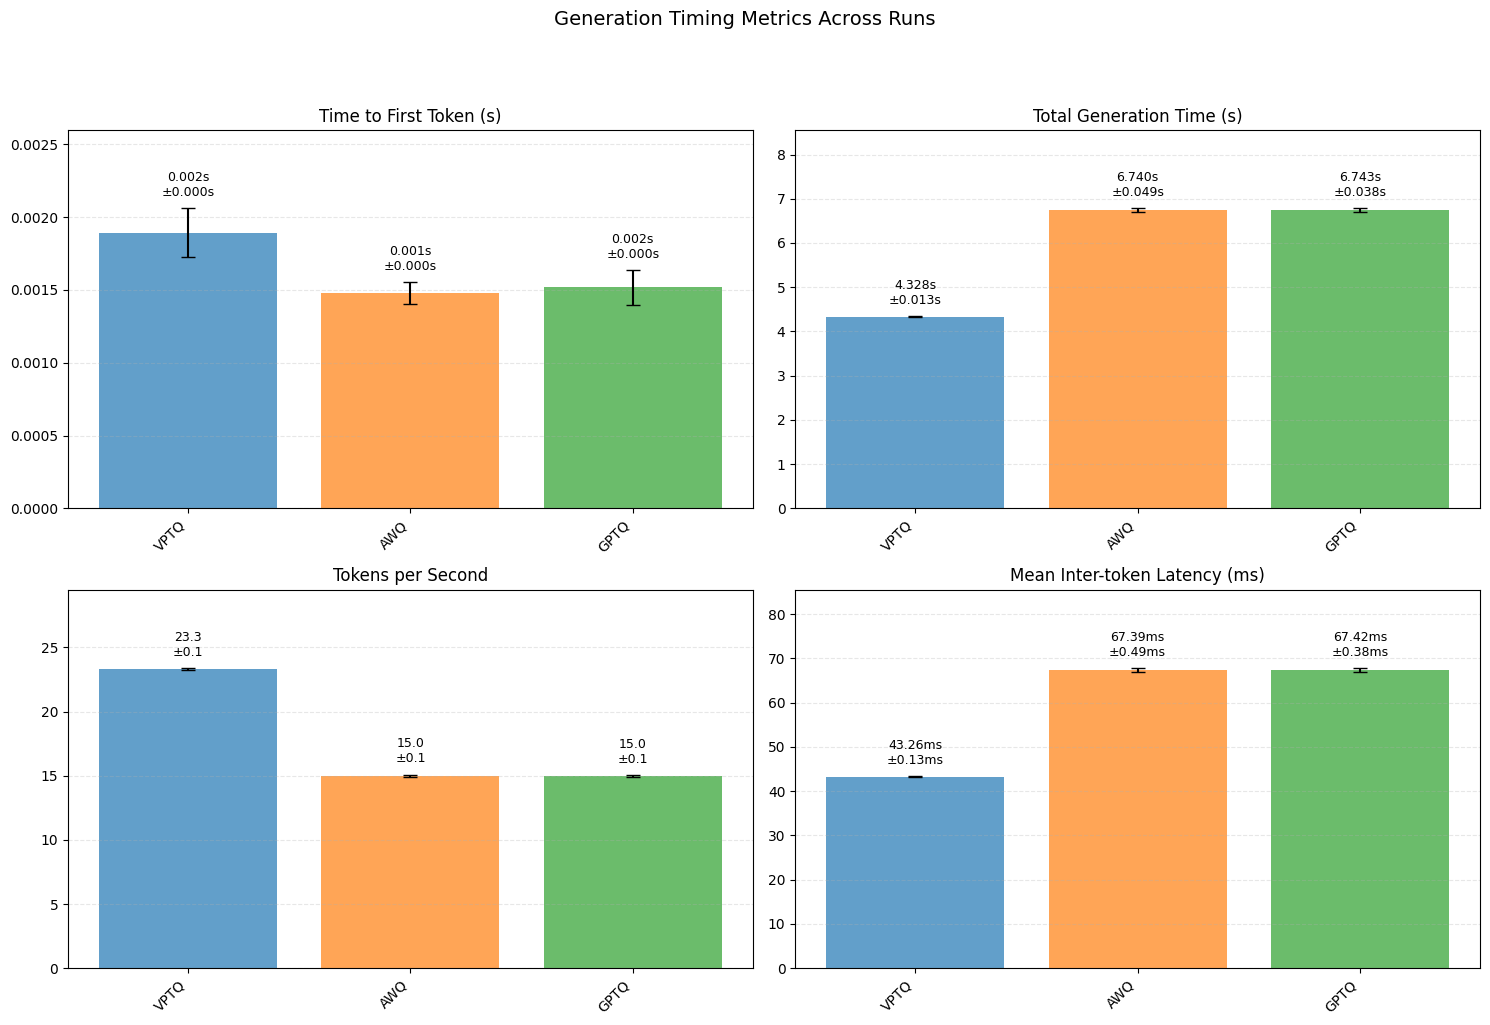

=== Key Metrics Summary ===

Mean Total Time:
mean     5.937321
std      1.393449
min      4.328306
max      6.743436
cv      23.469317

Mean First Token:
mean     0.001629
std      0.000229
min      0.001479
max      0.001893
cv      14.043318

Mean Tokens Per Second:
mean    17.766091
std      4.822780
min     14.977947
max     23.334955
cv      27.145981

Mean Inter Token Latency:
mean     0.059357
std      0.013937
min      0.043264
max      0.067419
cv      23.479601

=== Run-over-run Changes ===

Absolute Differences:
                          VPTQ_to_AWQ_diff  AWQ_to_GPTQ_diff
mean_total_time                   2.411915          0.003215
mean_first_token                 -0.000414          0.000038
mean_tokens_per_second           -8.349585         -0.007424
mean_inter_token_latency          0.024123          0.000032

Percent Changes:
                          VPTQ_to_AWQ_pct_change  AWQ_to_GPTQ_pct_change
mean_total_time                            55.72                    0.05
m

In [ ]:
comparison = compare_aggregate_runs([
    ("VPTQ", vptq_results), ("AWQ",awq_results), ("GPTQ", gptq_results)
])

# Print formatted report
print(format_comparison_report(comparison))